In [33]:
# Overleaf
# https://www.overleaf.com/9836375457csrqydskhcmj

# Init

In [34]:
# Libraries
import numpy as np
from math import *
from scipy.stats import norm
import matplotlib.pyplot as plt

In [35]:
# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0
M = 100_000
np.random.seed(np.random.randint(1000))
Z = np.random.normal(0, 1, M)

# Monte Carlo

In [46]:
# !
# Should we only work in B-S world?
# !

# Finds value of an underlying at strike
def mc_value(S0, r, sigma, T, M):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())
        results[i] = S
    return results

# Finds value of option at strike
def mc_payoff(K, results, call, payoff_type):
    # Find option payoffs
    if payoff_type == "vanilla":
        if call:
            V = np.maximum(results - K, 0)
        else:
            V = np.maximum(K - results, 0)
    if payoff_type == "digital":
        if call:
            V = np.maximum(results - K, 0)
            V[V != 0] = 1
        else:
            V = np.maximum(K - results, 0)
            V[V != 0] = 1
    return V

# Finding Fair Value from Monte Carlo Simulation
mc_values = mc_value(S0, r, sigma, T, M)
mc_payoffs = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_payoffs)     # We have to discount the payoffs to calculate fair option's price
print(f"Option price: {option_price:.4f}")

# Finding Confidence Interval
standard_error = np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs))
t_stat = np.abs(norm.ppf(0.025))
margin_of_error = t_stat * standard_error
lower_bound = option_price - margin_of_error
upper_bound = option_price + margin_of_error
print(f"Standard error: {standard_error:.4f}")
print(f"95% Confidence interval: ({lower_bound:.4f}, {upper_bound:.4f})")


Option price: 0.5646
Standard error: 0.0049
95% Confidence interval: (0.5550, 0.5742)


In [47]:
'''
--------------------------------
| Black-Scholes Option Pricing |
--------------------------------
'''

def d1_d2(S0, K, r, sigma, T):
    d1 = (log(S0/K) + (r+sigma**2/2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return d1,d2

def call_option_price(S0, K, r, T, d1, d2):
    return S0*norm.cdf(d1) - K*exp(-r*T)*norm.cdf(d2)

def put_option_price(S0, K, r, T, d1,d2):
    return K*exp(-r*T)*norm.cdf(-d2) - S0*norm.cdf(-d1)

In [48]:
'''
--------------------------------
| Binomial-Tree Option Pricing |
--------------------------------
'''

def buildTree (S, vol , T, N):
    dt = T/N
    matrix = np.zeros((N+1, N+1))
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    for i in np.arange(N+1):        # iterate over rows
        for j in np.arange(i+1):    # iterate over columns
        # Hint : express each cell as a combination of up and down moves
            matrix[i, j] = S*(u**j * d**(i-j))

    return matrix 

def valueOptionMatrix (tree, T, N, r, K, vol, call=True):

    dt = T/N
    u = np.exp(vol*np.sqrt(dt))
    d = np.exp(-vol*np.sqrt(dt))    # Or 1/u
    p = (np.exp(r*dt)-d)/(u-d)      # risk-neutral probability

    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward, we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        S = tree[rows - 1, c]   # value in the matrix
        if call:
            tree[rows - 1, c] = max(0, S-K) # Should be higher than strike price, or worthless (Call case)
        else:
            tree[rows - 1, c] = max(0, K-S) # Should be higher than strike price, or worthless (Call case)

    # For all other rows, we need to combine from previous rows
    # We walk backwards, from the last row to the first row
    for i in np.arange(rows - 1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i + 1, j]
            up = tree[i + 1, j + 1]
            tree[i, j] = np.exp(-r*dt) * (p*up+(1-p)*down)

    return tree

For trials: [  100   200   300   400   500   600   700   800   900  1000  1100  1200
  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300  2400
  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500  3600
  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700  4800
  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900  6000
  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100  7200
  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300  8400
  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500  9600
  9700  9800  9900 10000]


100%|██████████| 100/100 [00:01<00:00, 90.45it/s]


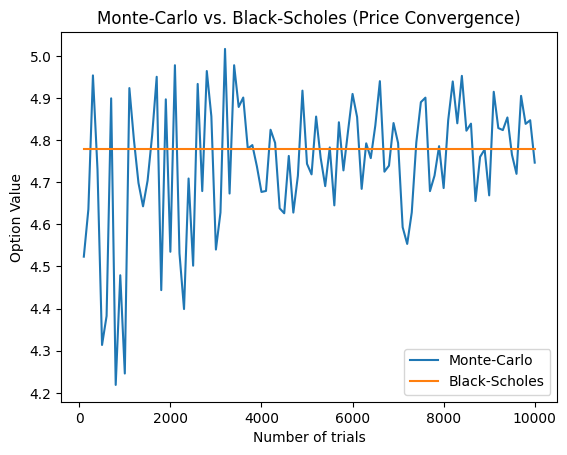

In [39]:
'''
-----------------------
| Convergence Studies |
-----------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Compare Monte-Carlo Option Price with Black-Scholes Option Price 
        for different number of trials (N) and calculate the absolute error.
        Then plot the put option's price for Monte-Carlo and Black-Scholes,
        along with the absolute error.
'''

from tqdm import tqdm

# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0

# Black-Scholes Option Price
d1, d2 = d1_d2(S0, K, r, sigma, T)
bs_answer = put_option_price(S0, K, r, T, d1, d2)

# Binomial-Tree Option Price
tree = buildTree(S0, sigma, T, 50) # N=50
bt_answer = valueOptionMatrix(tree, T, 50, r, K, sigma, False)[0,0]

option_prices = []   # List containing average option price of each trail
bs_abs_errors = []   # List containing absolute error of each trail
bt_abs_errors = []   # List containing absolute error of each trail

# List containing number of trials
trials = np.linspace(100, 10_000, 100, dtype=int)
print("For trials:", trials)

for M in tqdm(trials):

    # Get stock price development
    values_history = mc_value(S0, r, sigma, T, M)

    # Get option price development
    payoff_history = mc_payoff(K, values_history, call=False, payoff_type='vanilla')

    # Get fair option price and append
    option_price = np.exp(-r * T) * np.mean(payoff_history)
    option_prices.append(option_price)

    # Caclulate and append absolute error
    bs_abs_errors.append(np.abs(option_price - bs_answer))
    bt_abs_errors.append(np.abs(option_price - bt_answer))

# Plot Price Convergence Monte-Carlo vs. Black-Scholes
plt.title("Monte-Carlo vs. Black-Scholes (Price Convergence)")
plt.plot(trials, option_prices, label="Monte-Carlo")                                 # Plot Monte-Carlo option price development 
plt.plot(trials, [bs_answer for i in range(len(trials))], label="Black-Scholes")     # Plot Black-Scholes option price development
# plt.plot(trials, [bt_answer for i in range(len(trials))], label="Binomial Tree")     # Plot Binomial Tree option price development
plt.xlabel("Number of trials")
plt.ylabel("Option Value")
plt.legend()

Final Absolute Error: 0.1261190820573308


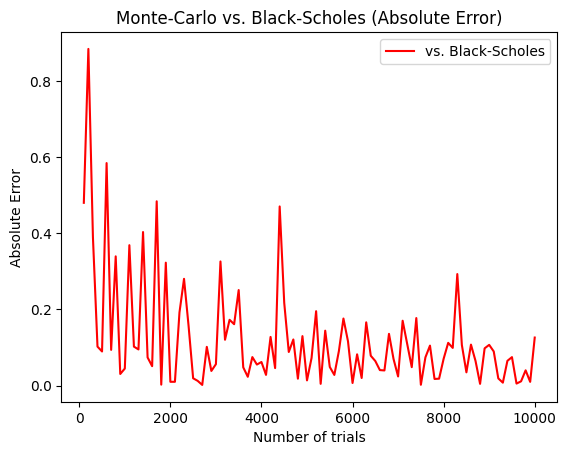

In [8]:
print("Final Absolute Error:", bs_abs_errors[-1])
# Plot Absolute Error for N trials (Monte-Carlo vs. Black-Scholes)
plt.title("Monte-Carlo vs. Black-Scholes (Absolute Error)")
plt.plot(trials, bs_abs_errors, label="vs. Black-Scholes", c='r')    
# plt.plot(trials, bt_abs_errors, label="vs. Binomial Tree", c='g')    
plt.xlabel("Number of trials")
plt.ylabel("Absolute Error")
plt.legend()

For Strike Prices: [  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300]


100%|██████████| 21/21 [00:03<00:00,  5.88it/s]


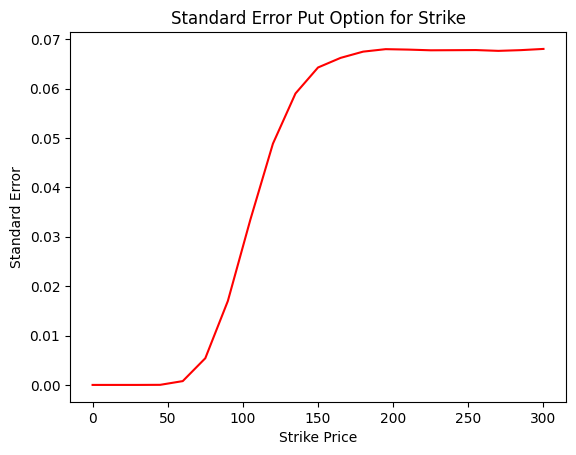

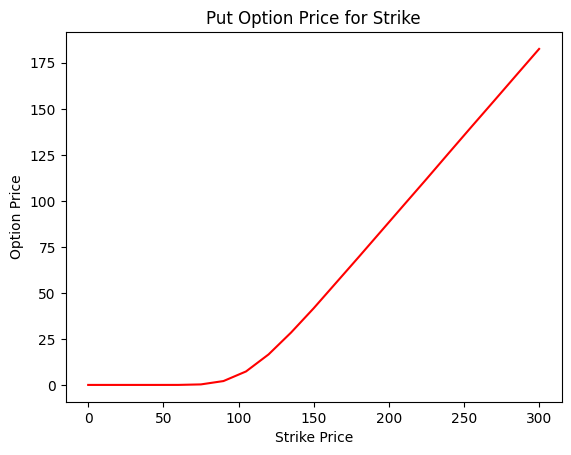

In [9]:
'''
---------------------------------
| Numerical Test (Strike-Price) |
---------------------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Calculate the option price for different strike prices
        with Monte-Carlo method and determine standard error.
'''

# Option Characteristics
S0 = 100
strike_prices = np.linspace(0, 300, 21, dtype=int)
r = 0.06
sigma = 0.2
T = 1.0

M = 100_000     # Time discretization

std_errs = []           # List containing standard error of each strike price
option_price_at_k = []  # List containing option price of each strike price

print("For Strike Prices:", strike_prices)
for K in tqdm(strike_prices):
    
    # Get underlying value development
    mc_values = mc_value(S0, r, sigma, T, M)

    # Get option price development
    mc_payoffs = mc_payoff(K, mc_values, call=False, payoff_type='vanilla')

    # Get fair option price
    option_price = np.exp(-r * T) * np.mean(mc_payoffs)
    option_price_at_k.append(option_price)

    # Calculate and append standard error
    std_errs.append(np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs)))

plt.title("Standard Error Put Option for Strike")
plt.plot(strike_prices, std_errs, c='r')
plt.xlabel("Strike Price")
plt.ylabel("Standard Error")
plt.show()

plt.title("Put Option Price for Strike")
plt.plot(strike_prices, option_price_at_k, c='r')
plt.xlabel("Strike Price")
plt.ylabel("Option Price")
plt.show()


For Sigmas: [0.    0.125 0.25  0.375 0.5   0.625 0.75  0.875 1.    1.125 1.25  1.375
 1.5   1.625 1.75  1.875 2.    2.125 2.25  2.375 2.5  ]


100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


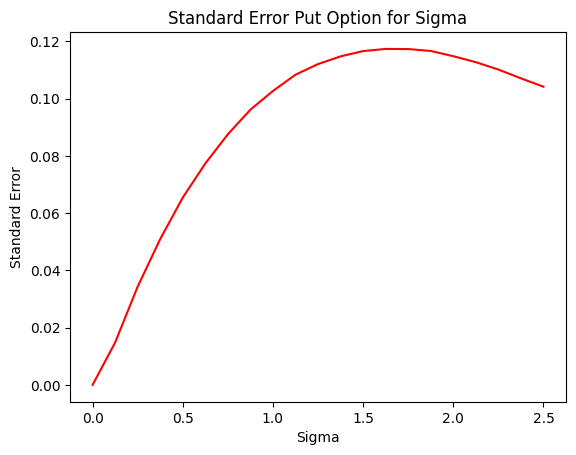

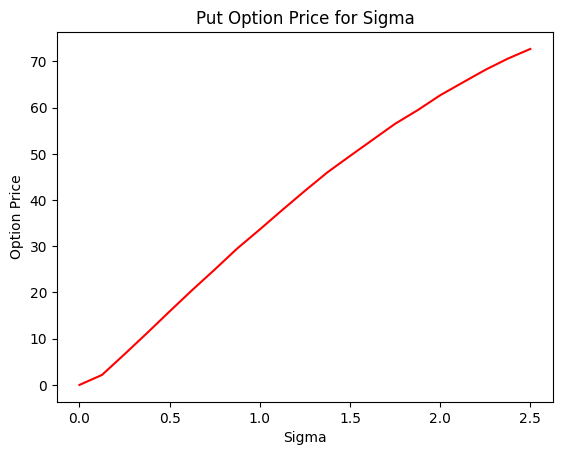

In [10]:
'''
--------------------------
| Numerical Test (Sigma) |
--------------------------
Option Characteristics:
    S0 = 100
    K = 99
    r = 0.06
    sigma = 0.2
    T = 1.0

Method: Calculate the option price for different sigmas with
        Monte-Carlo method and determine standard error.
'''

# Option Characteristics
S0 = 100
K = 99
r = 0.06
sigmas = np.linspace(0.0, 2.5, 21)
T = 1.0

M = 100_000     # Time discretization

std_errs = []                # List containing standard error for each sigma
option_price_at_sigma = []   # List containing option price of each sigma

print("For Sigmas:", sigmas)
for sigma in tqdm(sigmas):

    # Get underlying value development
    mc_values = mc_value(S0, r, sigma, T, M)

    # Get option price development
    mc_payoffs = mc_payoff(K, mc_values, call=False, payoff_type='vanilla')

    # Get fair option price
    option_price = np.exp(-r * T) * np.mean(mc_payoffs)
    option_price_at_sigma.append(option_price)

    # Calculate standard error
    std_errs.append(np.std(mc_payoffs, ddof=1) / np.sqrt(len(mc_payoffs)))


plt.title("Standard Error Put Option for Sigma")
plt.plot(sigmas, std_errs, c='r')
plt.xlabel("Sigma")
plt.ylabel("Standard Error")
plt.show()

plt.title("Put Option Price for Sigma")
plt.plot(sigmas, option_price_at_sigma, c='r')
plt.xlabel("Sigma")
plt.ylabel("Option Price")
plt.show()

# Approximating Delta

Should run each test for multiple times and show the confidence interval of deviation. With seed is much more stable

In [49]:
# Modified MC to support given random Z distribution values

def mc_value_seed(S0, r, sigma, T, M, Z):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z[i])
        results[i] = S
    return results

In [50]:
# Finite Difference Method (with one side difference)

# Finding New Prices
finite_difference_step = 10.0            # Is not stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_delta, r, sigma, T, M)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0162


In [54]:
# Finite Difference Method (with one side difference and fixed seed)

# Setting seed and generating values


# Finding New Prices
finite_difference_step = 0.1            # Is much more stable with lower values
S_delta = S0 + finite_difference_step

# Finding Approxiamation for Higher Price
mc_values = mc_value_seed(S0, r, sigma, T, M, Z)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price = np.exp(-r * T) * np.mean(mc_results)
# Finding Approxiamation for Lower Price
mc_values = mc_value_seed(S_delta, r, sigma, T, M, Z)
mc_results_diff = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_diff = np.exp(-r * T) * np.mean(mc_results_diff)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_diff - option_price) / finite_difference_step

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0217


In [47]:
# Finite Difference Method (With Lower and Higher)
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf - Notes on convergence

# Finding New Prices
finite_difference_step = 0.1
S_delta = S0 * finite_difference_step
S_up = S0 + S_delta
S_down = S0 - S_delta

# Finding Approxiamation for Higher Price
mc_values = mc_value(S_up, r, sigma, T, M)
mc_results_up = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_up = np.exp(-r * T) * np.mean(mc_results_up)
# Finding Approxiamation for Lower Price
mc_values = mc_value(S_down, r, sigma, T, M)
mc_results_down = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
option_price_down = np.exp(-r * T) * np.mean(mc_results_down)
# Approximation of Delta with Finite Differences
delta_approx = (option_price_up - option_price_down) / (2 * S_delta)

# Print the results
print(f"Delta approximation: {delta_approx:.4f}")

Delta approximation: 0.0004


# Sophisticated methods for approximating Delta

In [48]:
# Some material used:
# http://www.columbia.edu/~mh2078/MonteCarlo/MCS_Greeks.pdf
# https://people.maths.ox.ac.uk/gilesm/mc/module_6/adjoints/adjoints.pdf    # Not very useful
# https://math.maths.univ-evry.fr/kahmed/Lecture7.pdf                       # Not used
# https://github.com/Redmek/Pricing-and-Hedging-of-Exotic-Options-Under-Black-Scholes-and-Heston-Models/blob/main/Pricing_exotic_options.ipynb
# http://arno.uvt.nl/show.cgi?fid=146124        # Might be usefull for report

In [49]:
# Pathwise for Vanilla Option (Does not work with digital)
# https://quant.stackexchange.com/questions/33695/pathwise-derivative-to-estimate-delta

# Monte Carlo
mc_values = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, mc_values, call = True, payoff_type = "digital")
# Finding distribution of results
I = [1 if i != 0 else 0 for i in mc_results]            # DID I UNDERSTOOD IT CORRECTLY?
deltas = np.exp(-r * T)*(mc_values/S0)*mc_results
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

Delta approximation with Pathwise: 0.8407


In [50]:
# Pathwise for Smoothed

mc_values = mc_value(S0, r, sigma, T, M)

# !
# Ask how and why it is supposedly works. Also where I can read about all of this in greater detail
# !

# The digital option is essentially an indicator function with jump at K, and hence the derivative in K does not exist.
# We approximate the option payoff with a smooth function (normal-cdf with small variance)
# We use a sigmoid here to approximate the indicator function
def sigmoid(K, values): 
  result =  1/(1+np.exp(-values + K))
  return result

# Derivative of our indicator proxy referencing the underlying x
def digital_sigmoid(K, values):
  result = sigmoid(K, values) * (1 - sigmoid(K, values))
  return result

I = digital_sigmoid(K, mc_values)
deltas = np.exp(-r * T)*(mc_values/S0)*I
    
#Test
print(f"Delta approximation with Pathwise: {np.mean(deltas):.4f}")

Delta approximation with Pathwise: 0.0004


In [51]:
# Likelihood for Vanilla and Digital Option
# https://github.com/hongwai1920/Implement-Option-Pricing-Model-using-Python
# https://nbviewer.org/github/hongwai1920/Implement-Option-Pricing-Model-using-Python/blob/master/2.%20digital%20Greeks%20using%20finite%20difference%2C%20pathwise%20derivative%20estimate%20and%20likelihood%20ratio%20methods.ipynb
# And the paper on Canvas

# Monte Carlo
ST = mc_value(S0, r, sigma, T, M)
mc_results = mc_payoff(K, ST, call = True, payoff_type = "digital")     # Change to digital to find digital option, it just makes mc_results to 0 and 1, thus I

# Calculating Delta with Likelihood method
Z = (np.log( ST / S0 ) - (r - 0.5 * sigma**2) * T) / (S0 * sigma**2 * T)
deltas = np.exp(-r * T) * mc_results * Z

print(f"Delta approximation with Likelihood: {np.mean(deltas):.4f}")

Delta approximation with Likelihood: 0.0004


!

Should we add more greeks?

!

# Asian Option

In [115]:
S0 = 100
K = 99
r = 0.06
sigma = 0.2
T = 1.0


def d1_d2(S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r+(sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return d1,d2
def european_call_option_price_w_asian_interest(S0, K, r, asian_r,T, d1, d2):
    return np.exp(-r*T)*(S0*np.exp(asian_r*T)*norm.cdf(d1) - K*norm.cdf(d2))
def vanilla_euro_call(S0, K, r,T, d1, d2):
    return S0*norm.cdf(d1)-K*np.e**(-r*T)*norm.cdf(d2)
N = 3650
d1,d2=d1_d2(S0=S0,K=K,r=r,sigma=sigma,T=T)
print('vanilla bs call')
print(vanilla_euro_call(S0=S0,K=K,r=r,T=T,d1=d1,d2=d2))


def asian_call_option_price(S0,N=N,sigma=sigma,K=K,r=r, T=T):

    asian_sigma = sigma*np.sqrt((2*N+1)/(6*(N+1)))
    asian_risk_free_interest = 0.5*((r-0.5*sigma**2) + asian_sigma**2)
    d1,d2=d1_d2(S0,K,asian_risk_free_interest, asian_sigma, T)
    A_N = european_call_option_price_w_asian_interest(S0, K,r , asian_risk_free_interest, T,d1, d2)
    return A_N, asian_sigma


def control_variate(asian_call_price, asian_sigma, paths=100, r=r,sigma=sigma, N=N, K=K, rho=0.99 ):
    Z = np.random.normal(0,1,paths)
    exponent = (r-0.5*sigma**2)*T+sigma*np.sqrt(T)*Z

    mean = np.prod(S0*e**exponent)**(1/(N+1))
    print(mean)
    call_bs_head = max(0,mean-K)
    asian_call_head = max(0, np.mean(S0*e**exponent)-K)
    cv_asian = asian_call_head-rho*sigma/asian_sigma*(call_bs_head-asian_call_price)
    return cv_asian
N = 3650

prices = np.linspace(10,150,200)
asian_call_price,asian_sigma  = asian_call_option_price(S0=S0)
cv_asian = control_variate(asian_call_price,asian_sigma)
print(cv_asian, asian_call_price)


vanilla bs call
11.544280227051097
1.1357873459855543
18.727369970538767 6.3348930604533775


In [116]:
def bs_paths(path_count=100,steps=N,T=1, K=K, sigma=sigma, S0=S0):
    all_paths = []


    for path in range(path_count):
        path_points = np.zeros(steps)
        path_points[0] = S0
        Z = np.random.normal(0,1,steps)
        for step in range(1,steps):
            path_points[step] = path_points[step-1]*(1+r*T/steps+sigma*np.sqrt(T/steps)*Z[step])

        all_paths.append(path_points)

    return np.array(all_paths)

def mc_value(S0=S0, r=r, sigma=sigma, T=T, M=100):
    #dt = T/1    # N=1 Because of Geometric Brownian-Motion we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.
    results = np.zeros(M)
    # Monte-Carlo Runs
    for i in range(M):
        S = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * np.random.normal())
        results[i] = S
    return results
# print(np.mean(mc_value()))

def monte_carlo_option_price(r=r,T=T, K=K, path_count = 1000, steps=N):

    paths =mc_value(M=path_count)
    return np.exp(-r*T)*np.mean(np.maximum(paths-K,0))
def asian_call_payoff( K=K, r=r, T=T):
    paths = bs_paths()
    all_paths=[]
    for path in paths:
        S_T = np.mean(path)
        Z = np.maximum(S_T-K, 0)
        all_paths.append(np.exp(-r*T) * Z)
    return all_paths
monte_carlo_option_price()


11.848254384960567

1.1357322646784629
1.136152652533523
1.135800751792335
1.1367022845310002
1.1365029921761671
1.1358436714635276
1.136518600589704
1.136579734143614
1.136141694514212


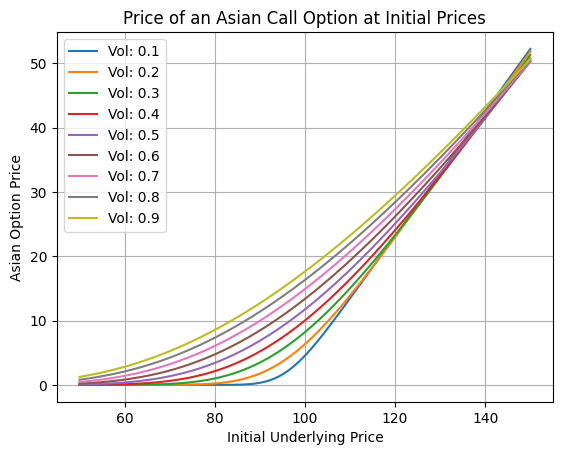

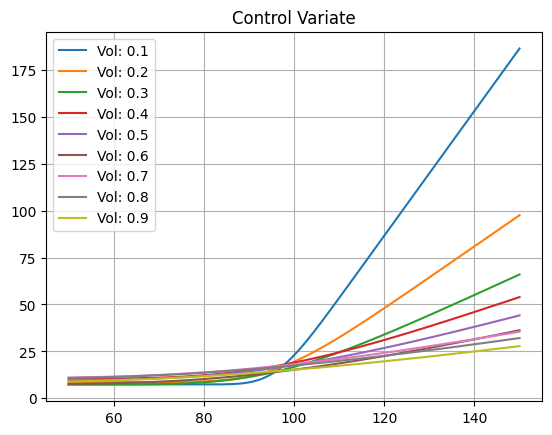

In [117]:
price =np.linspace(50,150,500)
volatilities = np.round(np.linspace(0.1,0.9,9), 1)
cv_points = []
mc_points = []
for volatility in volatilities:
    asian_call_option = asian_call_option_price(S0=price, sigma=volatility)
    plt.plot(price, asian_call_option[0], label=f'Vol: {volatility}')
#     mc_value = mc_value(price, r, volatility, T, M)
#     mc_points.append(mc_value)
    cv_points.append(control_variate(asian_call_option[0],asian_call_option[1]))

    
    
    
plt.title('Price of an Asian Call Option at Initial Prices')
plt.xlabel('Initial Underlying Price')
plt.ylabel('Asian Option Price')
plt.grid()
plt.legend()
plt.show()
i=0
for cv_point in cv_points:
    plt.plot(price,cv_point,label=f'Vol: {volatilities[i]}')
    i+=1
plt.title('Control Variate')
plt.grid()
plt.legend()
plt.show()



In [118]:
trials = np.linspace(100, 10_000, 100, dtype=int)


100%|██████████| 3649/3649 [00:15<00:00, 240.61it/s]


11.537545436901105


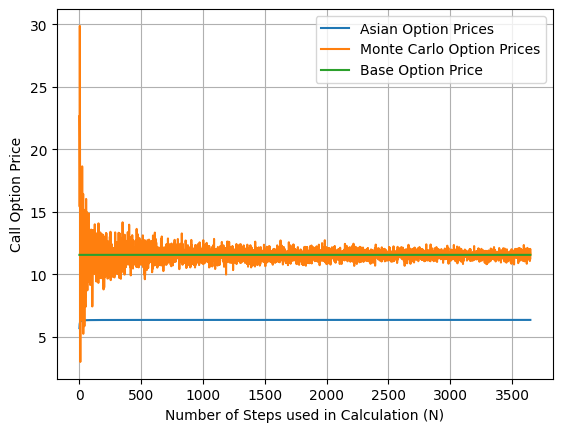

In [119]:
N=3650
asian_option_price = asian_call_option_price(S0, N,sigma, K, r,T)
# print(f"Asian Option price: {asian_option_price:.4f}")
all_n_vals = []
option_prices = []
mc_option_prices = []
for i in tqdm(range(1,N)):
    option_prices.append(asian_call_option_price(S0, i,sigma, K, r,T)[0])
    mc_option_prices.append(monte_carlo_option_price(path_count=i))
plt.plot(range(1,N),option_prices, label="Asian Option Price")
print(np.mean(mc_option_prices))
plt.plot(range(1,N),mc_option_prices, label="Monte Carlo Option Prices")
call_base = vanilla_euro_call(S0=S0,K=K,r=r,T=T,d1=d1,d2=d2)

plt.plot(range(1,N),np.ones(N-1)*call_base, label="Base Option Price" )
plt.grid()
plt.legend()
plt.xlabel("Number of Steps used in Calculation (N)")
plt.ylabel("Call Option Price")
plt.show()